# COVID19 - Brazil States

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [103]:
import urllib.request
import pandas as pd
import numpy as np

In [104]:
# Download data
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...


In [105]:
df = pd.read_csv("data/dados_total_estados.csv")
df

,index,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,0,2020-06-02,RR,TOTAL,state,4143,124,69,True,605761.0,14.0,683.93310,0.0299
1,1,2020-06-01,RR,TOTAL,state,3850,120,68,False,605761.0,14.0,635.56419,0.0312
2,2,2020-05-31,RR,TOTAL,state,3692,116,67,False,605761.0,14.0,609.48130,0.0314
3,3,2020-05-30,RR,TOTAL,state,3474,116,66,False,605761.0,14.0,573.49351,0.0334
4,4,2020-05-29,RR,TOTAL,state,3299,110,65,False,605761.0,14.0,544.60423,0.0333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,154350,2020-03-13,AL,TOTAL,state,1,0,5,False,3337357.0,27.0,0.02996,0.0000
2169,154351,2020-03-12,AL,TOTAL,state,1,0,4,False,3337357.0,27.0,0.02996,0.0000
2170,154352,2020-03-10,AL,TOTAL,state,1,0,3,False,3337357.0,27.0,0.02996,0.0000
2171,154353,2020-03-09,AL,TOTAL,state,1,0,2,False,3337357.0,27.0,0.02996,0.0000


In [106]:
# Model

In [107]:
states=['SP','ES','MG','RJ','PE','CE','AM']
states

['SP', 'ES', 'MG', 'RJ', 'PE', 'CE', 'AM']

'# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [108]:
#objective function Odeint solver
from scipy.integrate import odeint

#objective function Odeint solver
def lossOdeint(point, data, death, s_0, e_0, a_0, i_0, r_0, d_0, startNCases, ratioRecovered, weigthCases, weigthRecov):
    size = len(data)
    beta, beta2, sigma, sigma2, sigma3, gamma, b, mu = point
    def SEAIRD(y,t):
        S = y[0]
        E = y[1]
        A = y[2]
        I = y[3]
        R = y[4]
        D = y[5]
        p=0.2
        # beta2=beta
        y0=-(beta2*A+beta*I)*S-mu*S #S
        y1=(beta2*A+beta*I)*S-sigma*E-mu*E #E
        y2=sigma*E*(1-p)-gamma*A-mu*A #A
        y3=sigma*E*p-gamma*I-sigma2*I-sigma3*I-mu*I#I
        y4=b*I+gamma*A+sigma2*I-mu*R #R
        y5=(-(y0+y1+y2+y3+y4)) #D
        return [y0,y1,y2,y3,y4,y5]

    y0=[s_0,e_0,a_0,i_0,r_0,d_0]
    size = len(data)+1
    tspan=np.arange(0, size+100, 1)
    res=odeint(SEAIRD,y0,tspan) #,hmax=0.01)

    # calculate fitting error by using numpy.where
    ix= np.where(data.values >= startNCases)
    l1 = np.mean((res[ix[0],3] - data.values[ix])**2)
    l2 = np.mean((res[ix[0],5] - death.values[ix])**2)
    l3 = np.mean((res[ix[0],4] - data.values[ix]*ratioRecovered)**2)

    #weight for cases
    u = weigthCases
    #weight for recovered
    w = weigthRecov 
    #weight for deaths
    v = max(0,1. - u - w)

    #calculate derivatives
    #and the error of the derivative between prediction and the data

    #for deaths
    dDeath=np.diff(res[1:size,5])
    dDeathData=np.diff(death.values.T[0][:])
    dErrorX=(dDeath-dDeathData)**2
    dErrorD=np.mean(dErrorX[-15:]) 

    #for infected
    dInf=np.diff(res[1:size,3])
    dInfData=np.diff(data.values.T[0][:])
    dErrorY=(dInf-dInfData)**2
    dErrorI=np.mean(dErrorY[-15:])

    #objective function
    gtot=u*(l1+0.2*dErrorI) + v*(l2+0.2*dErrorD) + w*l3

    #penalty function for negative derivative at end of deaths
    NegDeathData=np.diff(res[:,5])
    dNeg=np.mean(NegDeathData[-5:]) 
    correctGtot=max(abs(dNeg),0)**2

    #final objective function
    gtot=correctGtot-min(np.sign(dNeg),0)*correctGtot+gtot
    
    return gtot

In [109]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam = dfparam.dropna()
dfparam

,state,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,SP,2020-03-20,200,8000000.0,0.0001,0.0001,800,300,400,100,0.15,0.55,0.1
1,ES,2020-04-01,200,500000.0,0.0001,0.0001,50,10,100,100,0.10,0.65,0.0
2,MG,2020-04-01,200,2000000.0,0.0001,0.0001,100,100,50,100,0.05,0.55,0.1
3,RJ,2020-04-01,200,2000000.0,0.0001,0.0001,100,100,50,100,0.05,0.55,0.1
4,CE,2020-04-01,200,2000000.0,0.0001,0.0001,100,100,50,100,0.05,0.55,0.1
5,PE,2020-04-01,200,2000000.0,0.0001,0.0001,100,100,50,100,0.05,0.55,0.1
6,AM,2020-04-01,200,2000000.0,0.0001,0.0001,100,100,50,100,0.05,0.55,0.1


In [110]:
# Initial parameter optimization

In [111]:
import ray
ray.init()

# Load solver
GlobalOptimization = False
Yabox = True

if GlobalOptimization:
    import LearnerGlobalOpt as Learner  # basinhopping global optimization (several times minimize)
elif Yabox:
    import LearnerYabox as Learner #Yabox
else:
    import Learner as Learner #minimize

2020-06-05 08:55:46,077	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2020-06-05 08:55:46,078	INFO resource_spec.py:205 -- Starting Ray with 38.77 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [95]:
allStates=False
cleanRecovered=False
version="1"

results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        parameters
        learner = Learner.Learner.remote(state, lossOdeint, *parameters, cleanRecovered, version)
        #learner.train()
        #add function evaluation to the queue
        results.append(learner.train.remote())
else:
    state= "ES"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    print(parameters)
    cleanRecovered = False
    learner = Learner.Learner.remote(state, lossOdeint, *parameters, cleanRecovered, version)
    #learner.train()
    #add function evaluation to the queue
    results.append(learner.train.remote())

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

01:59, 5109.68it/s]
100%|█████████▉| 1999000/2000000 [14:40<00:00, 6409.60it/s]


In [96]:
ray.shutdown()

100%|█████████▉| 1999000/2000000 [14:41<00:00, 2268.74it/s]


# Plots

In [97]:
%matplotlib inline 
import matplotlib.pyplot as plt
import covid_plots

In [98]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [99]:
selectedState='ES'

#select districts for plotting
states4Plot=['MG',
               'SP',
               'RJ',
               'CE',
               selectedState]

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#versio'n to identify the png file result
# version = "1"

#parameters for plotting
query = dfparam.query('state == "{}"'.format(state)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]

#number of cases to start plotting model in log graph - real data = 100
startCase=100

In [100]:
#do not allow the scrolling of the plots

In [101]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

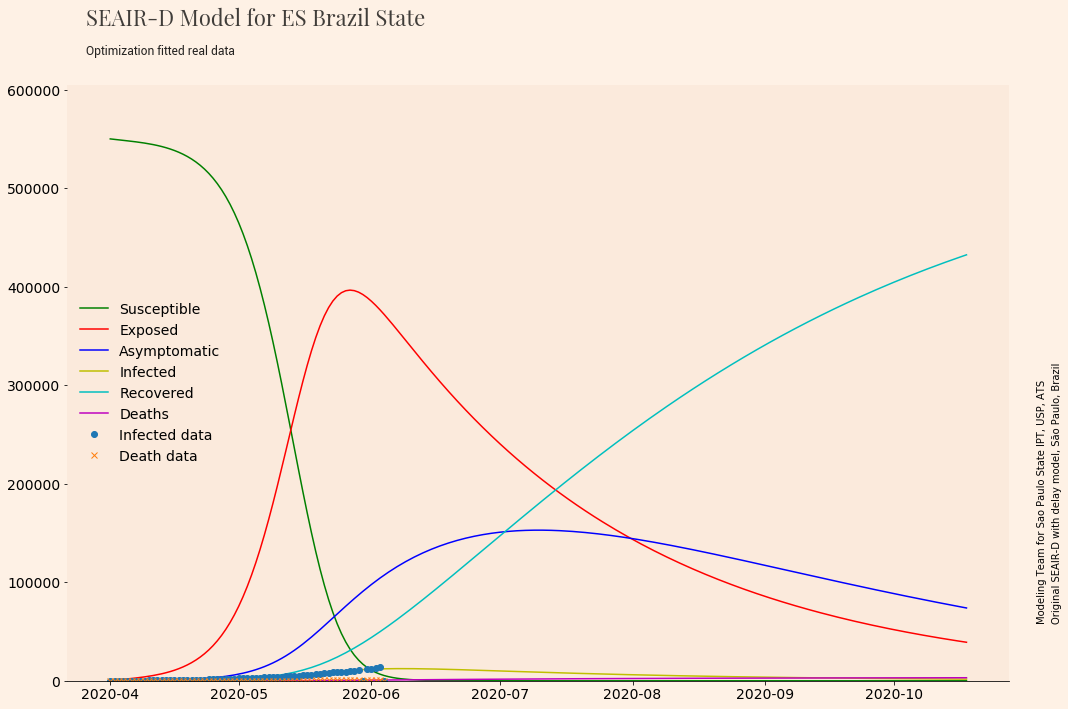

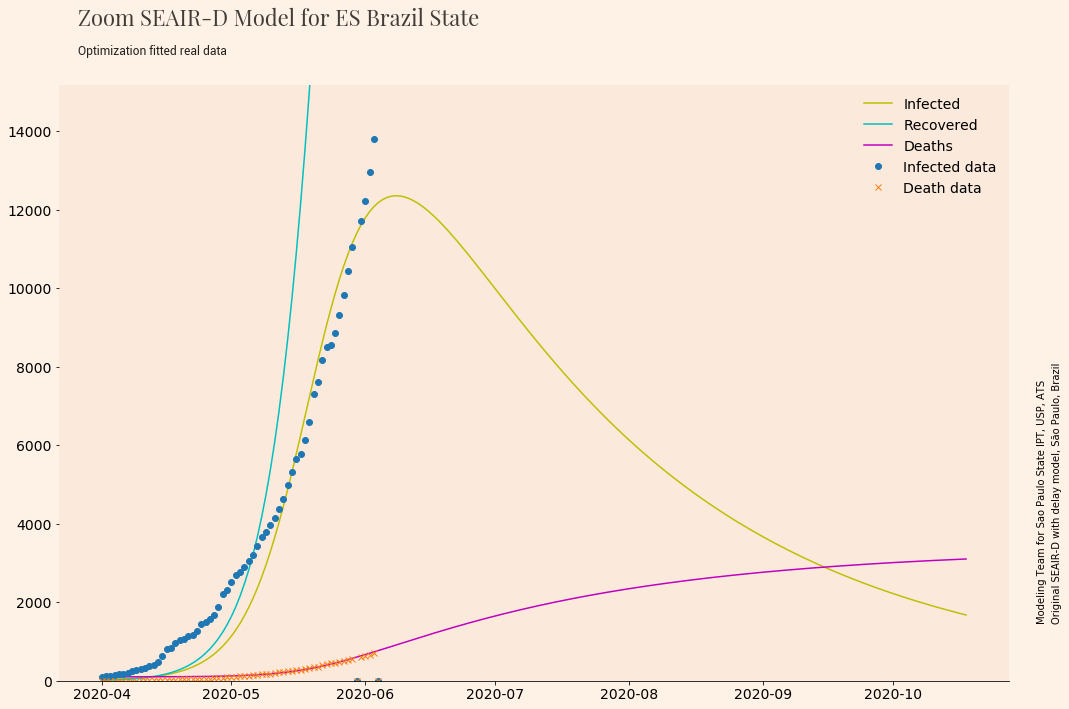

In [102]:
#plots one district or all districts

if allStates:
    for state in states:
        covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                                startCase, 5, version, show=True)
else: 
    covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                                startCase, opt, version, show=True)